<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/crypto_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [23]:
# Function to fetch and prepare data for multiple tickers
def fetch_and_prepare_data(tickers, start_date, end_date):
    combined_data = pd.DataFrame()

    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        data.ffill(inplace=True)  # Forward fill any null values
        data = data[['Close']].rename(columns={'Close': ticker})

        if combined_data.empty:
            combined_data = data
        else:
            combined_data = combined_data.join(data, how='outer')

    combined_data.ffill(inplace=True)  # Forward fill any remaining null values after join
    return combined_data


In [24]:
# Example usage
tickers = ['BTC-USD', 'ETH-USD', 'LTC-USD']
start_date = '2020-01-01'
end_date = '2024-07-30'
data = fetch_and_prepare_data(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [25]:
# Function to normalize data
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data, scaler

# Normalize data
normalized_data, scaler = normalize_data(data)


In [26]:
# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step, 0])  # Predict the first coin (e.g., BTC-USD)
    return np.array(X), np.array(Y)

# Create dataset
time_step = 60
X, Y = create_dataset(normalized_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], len(tickers))  # Reshape for LSTM input


In [27]:
# Function to build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))  # Predict the price of the first coin
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_model((time_step, len(tickers)))
model.fit(X, Y, batch_size=1, epochs=50)


1611/1611 [==============================] - 58s 34ms/step - loss: 0.0035


In [28]:
def update_model_with_real_time_data(model, scaler, tickers, time_step=60):
    new_data = {}

    for ticker in tickers:
        new_data[ticker] = yf.download(ticker, period='1d', interval='1m')['Close']

    new_data = pd.DataFrame(new_data).ffill().values

    if new_data.shape[0] <= time_step:
        print("Not enough data to update the model.")
        return

    normalized_new_data = scaler.transform(new_data)

    for i in range(len(normalized_new_data) - time_step - 1):
        x = normalized_new_data[i:(i + time_step)]
        x = x.reshape(1, time_step, len(tickers))
        y = normalized_new_data[i + time_step, 0]

        model.train_on_batch(x, np.array([y]))

# Example usage for real-time data update
update_model_with_real_time_data(model, scaler, tickers)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 1s 1s/step
Predicted price for BTC-USD: 67185.265625


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 36ms/step
Predicted price for BTC-USD: 67176.9765625


KeyboardInterrupt: 

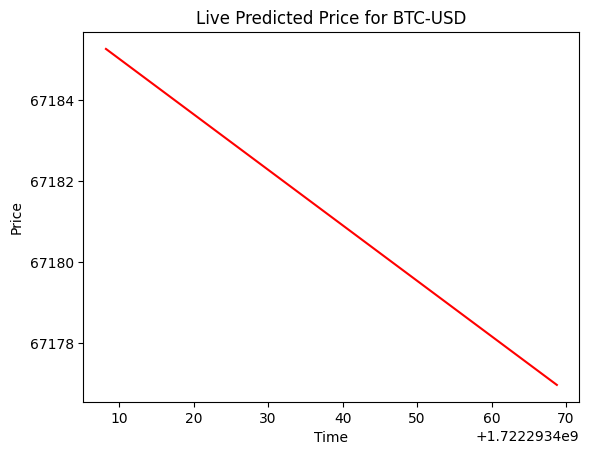

In [29]:
# prompt: can we make a live visual fro the above prediction with should indicate live predicted values

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import time

# ... (Your existing code for fetching, preparing, normalizing data, building and training the model) ...

def make_trading_decision(model, scaler, tickers, time_step=60):
    plt.ion()  # Turn on interactive mode for live plotting
    fig, ax = plt.subplots()
    line, = ax.plot([], [], 'r-')  # Initialize an empty plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title(f'Live Predicted Price for {tickers[0]}')
    x_data = []
    y_data = []

    while True:
        new_data = {}

        for ticker in tickers:
            new_data[ticker] = yf.download(ticker, period='1d', interval='1m')['Close']

        new_data = pd.DataFrame(new_data).ffill().values

        if new_data.shape[0] <= time_step:
            print("Not enough data to make a prediction.")
            continue

        normalized_new_data = scaler.transform(new_data)

        # Predict the next price
        x = normalized_new_data[-time_step:]
        x = x.reshape(1, time_step, len(tickers))
        predicted_price_normalized = model.predict(x)

        # Reshape the predicted price to match scaler input shape
        predicted_price_normalized = predicted_price_normalized.reshape(-1, 1)

        # Inverse transform to get the actual price
        predicted_price = scaler.inverse_transform(np.tile(predicted_price_normalized, (1, len(tickers))))

        # Update plot data
        x_data.append(time.time())  # Use timestamp for x-axis
        y_data.append(predicted_price[0][0])

        # Update the plot
        line.set_data(x_data, y_data)
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Autoscale the view
        fig.canvas.draw()
        fig.canvas.flush_events()  # Update the plot on the screen

        print(f"Predicted price for {tickers[0]}: {predicted_price[0][0]}")

        # Sleep for a minute before the next prediction
        time.sleep(60)

# Start the trading bot with live visualization
make_trading_decision(model, scaler, tickers)


In [ ]:
# prompt: live visual is not shown

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime

# ... (Your existing code for fetching, preparing, normalizing data, building and training the model) ...

def make_trading_decision(model, scaler, tickers, time_step=60):
    fig = go.Figure()

    # Initial trace (empty)
    fig.add_trace(
        go.Scatter(x=[], y=[], mode='lines', name='Predicted Price')
    )

    fig.update_layout(title=f'Live Predicted Price for {tickers[0]}',
                      xaxis_title='Time',
                      yaxis_title='Price')

    # Display the figure
    fig.show(renderer="colab")  # Use 'colab' renderer for Google Colab

    x_data = []
    y_data = []

    while True:
        new_data = {}

        for ticker in tickers:
            new_data[ticker] = yf.download(ticker, period='1d', interval='1m')['Close']

        new_data = pd.DataFrame(new_data).ffill().values

        if new_data.shape[0] <= time_step:
            print("Not enough data to make a prediction.")
            continue

        normalized_new_data = scaler.transform(new_data)

        # Predict the next price
        x = normalized_new_data[-time_step:]
        x = x.reshape(1, time_step, len(tickers))
        predicted_price_normalized = model.predict(x)

        # Reshape the predicted price to match scaler input shape
        predicted_price_normalized = predicted_price_normalized.reshape(-1, 1)

        # Inverse transform to get the actual price
        predicted_price = scaler.inverse_transform(np.tile(predicted_price_normalized, (1, len(tickers))))

        # Update plot data
        x_data.append(datetime.datetime.now())  # Use datetime object for x-axis
        y_data.append(predicted_price[0][0])

        # Update the plot
        with fig.batch_update():
            fig.data[0].x = x_data
            fig.data[0].y = y_data

        print(f"Predicted price for {tickers[0]}: {predicted_price[0][0]}")

        # Sleep for a minute before the next prediction
        time.sleep(60)

# Start the trading bot with live visualization using Plotly
make_trading_decision(model, scaler, tickers)
